In [13]:
%matplotlib inline


''' This script plots SMART results, including:
        1) Innovation and lambda parameter
        2) Precipitation RMSE's
        3) Precipitation corr coef

    Usage:
        $ python plot_SMART_results.py <config_file_SMART>
'''

import xarray as xr
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
from scipy.io import savemat, loadmat

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh
import warnings
warnings.filterwarnings('ignore')

from tonic.io import read_configobj

from da_utils import (load_nc_and_concat_var_years, setup_output_dirs,
                      da_3D_to_2D_for_SMART, da_2D_to_3D_from_SMART, rmse,
                      to_netcdf_forcing_file_compress, calculate_rmse_prec,
                      calculate_corrcoef_prec, calculate_categ_metrics,
                      calculate_prec_threshold)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/civil/hydro/ymao/anacond

In [57]:
# ============================================================ #
# Process command line arguments
# Read config file
# ============================================================ #
# cfg = read_configobj(
#     '/civil/hydro/ymao/data_assim/control/run_SMART/ArkRed/GPM_SMAP_36km/'
#     'EnKS.lambda_0.5.Q9.3hourly.no_split_grid.window_1.cfg')
# cfg = read_configobj(
#     '/civil/hydro/ymao/data_assim/control/run_SMART/ArkRed/'
#     'ArkRed.EnKS.tune_to_truth.Q9.3hourly.cfg')
cfg = read_configobj(
    '/civil/hydro/ymao/data_assim/control/run_SMART/ArkRed/GPM_SMAP_36km/'
    'EnKS.lambda_to_nldas2.api0.98.prec_std1_phi0.rescale1.Q0.3.3hourly.'
    'no_split_grid.window_1.with_winter/smart.run_vic.cfg')

In [58]:
# ============================================================ #
# Check wether PLOT section is in the cfg file
# ============================================================ #
if 'PLOT' in cfg:
    pass
else:
    raise ValueError('Must have [PLOT] section in the cfg file to plot'
                     'SMART-corrected rainfall results!')

In [59]:
# ============================================================ #
# Process some input variables
# ============================================================ #
start_time = pd.to_datetime(cfg['SMART_RUN']['start_time'])
end_time = pd.to_datetime(cfg['SMART_RUN']['end_time'])
start_year = start_time.year
end_year = end_time.year
time_step = cfg['SMART_RUN']['time_step']  # [hour]
window_size = cfg['SMART_RUN']['window_size']  # number of timesteps

In [60]:
# ============================================================ #
# Set up output directory
# ============================================================ #
output_dir = setup_output_dirs(
                    os.path.join(cfg['CONTROL']['root_dir'],
                                 cfg['OUTPUT']['output_basedir']),
                    mkdirs=['plots.{}'.format(cfg['PLOT']['smart_output_from'])])\
             ['plots.{}'.format(cfg['PLOT']['smart_output_from'])]

output_subdir_maps = setup_output_dirs(
                            output_dir,
                            mkdirs=['maps'])['maps']
output_subdir_ts = setup_output_dirs(
                            output_dir,
                            mkdirs=['time_series'])['time_series']
output_subdir_data = setup_output_dirs(
                            output_dir,
                            mkdirs=['data'])['data']

In [61]:
# ============================================================ #
# Load data
# ============================================================ #
print('Load data...')

# --- Load origigal precip --- #
print('\tOriginal precip')
da_prec_orig = load_nc_and_concat_var_years(
    basepath=os.path.join(
        cfg['CONTROL']['root_dir'],
        cfg['PLOT']['orig_prec_basepath']),
    start_year=start_year,
    end_year=end_year,
    dict_vars={'prec_orig': cfg['PLOT']['orig_prec_varname']})\
        ['prec_orig'].sel(time=slice(start_time, end_time))
    
# --- Load truth precip --- #
print('\tTrue precip')
da_prec_truth = load_nc_and_concat_var_years(
    basepath=os.path.join(
        cfg['CONTROL']['root_dir'],
        cfg['PLOT']['truth_prec_basepath']),
    start_year=start_year,
    end_year=end_year,
    dict_vars={'prec_truth': cfg['PLOT']['truth_prec_varname']})\
        ['prec_truth'].sel(time=slice(start_time, end_time))


# --- Load SMART-corrected precip --- #
# Identify which SMART postprocessed directory to read from
if cfg['PLOT']['smart_output_from'] == 'post':
    smart_outdir = os.path.join(
        cfg['CONTROL']['root_dir'], cfg['OUTPUT']['output_basedir'], 'post_SMART')
elif cfg['PLOT']['smart_output_from'] == 'spatial_downscale':
    smart_outdir = os.path.join(
        cfg['CONTROL']['root_dir'], cfg['OUTPUT']['output_basedir'], 'post_spatial_downscaled')
elif cfg['PLOT']['smart_output_from'] == 'remap':
    smart_outdir = os.path.join(
        cfg['CONTROL']['root_dir'], cfg['OUTPUT']['output_basedir'], 'post_final_remapped')
# Load deterministic result
print('\tSMART-corrected, deterministic...')
da_prec_corrected = load_nc_and_concat_var_years(
    basepath=os.path.join(smart_outdir, 'prec_corrected.'),
    start_year=start_year,
    end_year=end_year,
    dict_vars={'prec_corr': 'prec_corrected'})['prec_corr'].sel(
        time=slice(start_time, end_time))

# --- Load lambda --- #
mat_lambda = os.path.join(
    cfg['CONTROL']['root_dir'],
    cfg['OUTPUT']['output_basedir'],
    'run_SMART',
    'lambda.mat')
lambda_fraction = loadmat(mat_lambda)['lambda']

# --- Load increment sum of API --- #
mat_increment = os.path.join(
    cfg['CONTROL']['root_dir'],
    cfg['OUTPUT']['output_basedir'],
    'run_SMART',
    'increment_sum.mat')
increment_sum = loadmat(mat_increment)['INCREMENT_SUM']  # [window, grid_cell]
increment_sum[0, :] = 0

# --- SMART innovation --- #
innov = loadmat(os.path.join(cfg['CONTROL']['root_dir'],
                             cfg['OUTPUT']['output_basedir'],
                             'run_SMART',
                             'innovation.mat'))['innovation']  # [time, pixel]

# --- Domain mask --- #
# Domain for plotting
da_mask = xr.open_dataset(os.path.join(
                cfg['CONTROL']['root_dir'],
                cfg['PLOT']['domain_nc']))['mask']
# Domain for SMART run
da_mask_smart = xr.open_dataset(os.path.join(
                cfg['CONTROL']['root_dir'],
                cfg['DOMAIN']['domain_file']))['mask']

Load data...
	Original precip
	True precip
	SMART-corrected, deterministic...


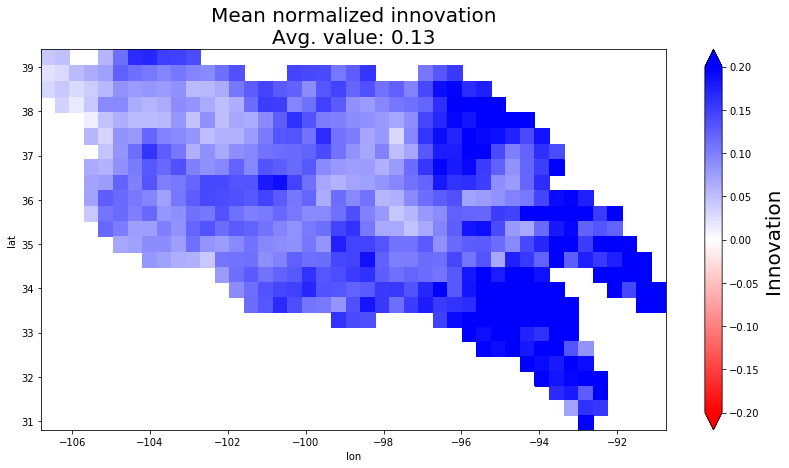

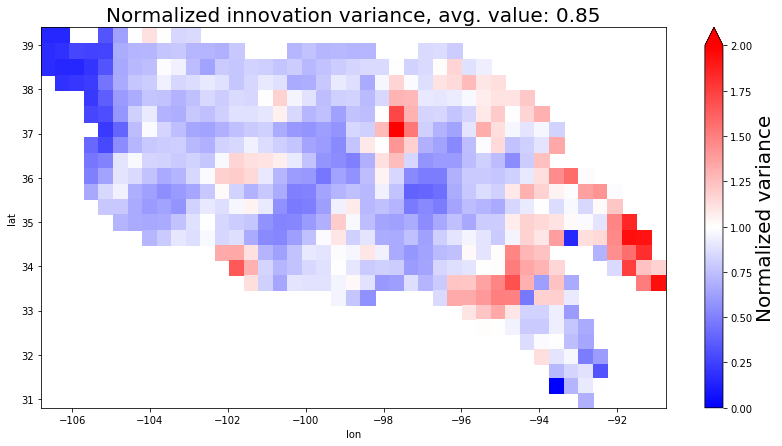

In [62]:
# ============================================================ #
# Plot innovation maps
# ============================================================ #
# --- Convert innovation to [time, lat, lon] --- #
da_innov = da_2D_to_3D_from_SMART(
                dict_array_2D={'innov': innov},
                da_mask=da_mask_smart,
                out_time_varname='time',
                out_time_coord=pd.date_range(start_time, end_time, freq='{}H'.format(time_step)))\
           ['innov']
# Remove -999 innovation values (for missing measurement time points)
innovation = da_innov.values
innovation[innovation==-999] = np.nan
da_innov[:] = innovation

# --- Plot --- #
# (1) Mean
da_innov_mean = da_innov.mean(dim='time')
fig = plt.figure(figsize=(14, 7))
cs = da_innov_mean.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.2, vmax=0.2)
cbar = plt.colorbar(cs, extend='both').set_label('Innovation', fontsize=20)
plt.title('Mean normalized innovation\n'
          'Avg. value: {:.2f}'.format(float(da_innov_mean.mean().values)),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'innov_mean.png'), format='png',
            bbox_inches='tight')

# (2) Normalized variance
da_innov_var = da_innov.var(dim='time')
fig = plt.figure(figsize=(14, 7))
cs = da_innov_var.plot(add_colorbar=False, cmap='bwr', vmin=0, vmax=2)
cbar = plt.colorbar(cs, extend='max').set_label('Normalized variance', fontsize=20)
plt.title('Normalized innovation variance, '
          'avg. value: {:.2f}'.format(float(da_innov_var.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'innov_var_norm.png'), format='png',
            bbox_inches='tight', pad_inches=0)

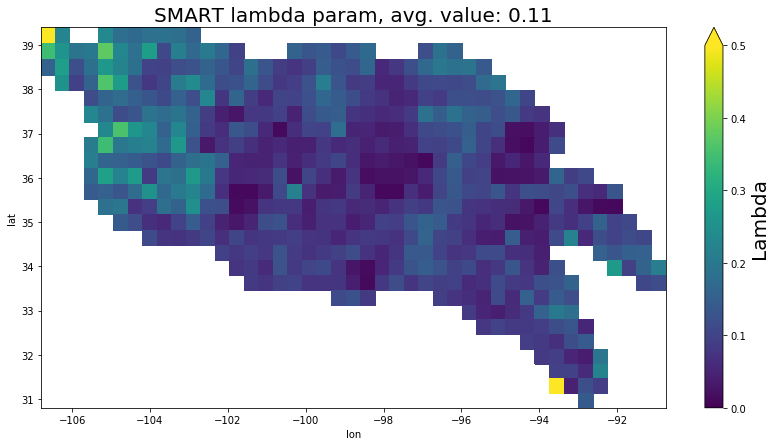

In [63]:
# ============================================================ #
# Plot lambda map
# ============================================================ #
# --- Convert lambda param to [lat, lon] --- #
da_lambda = da_2D_to_3D_from_SMART(
                dict_array_2D={'lambda': lambda_fraction},
                da_mask=da_mask_smart,
                out_time_varname='time',
                out_time_coord=['0'])['lambda'].sel(time='0')
# --- Lambda param map --- #
fig = plt.figure(figsize=(14, 7))
cs = da_lambda.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=0.5)
cbar = plt.colorbar(cs, extend='max').set_label('Lambda', fontsize=20)
plt.title('SMART lambda param, '
          'avg. value: {:.2f}'.format(float(da_lambda.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'lambda_param.png'), format='png',
            bbox_inches='tight', pad_inches=0)

In [64]:
# ============================================================ #
# Plot categorical metric
# ============================================================ #
# --- Setting --- #
# Aggregation freq
list_freq = ['3H', '1D', '3D']
# Percentile of threshold
list_perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]

# --- Calculate metrics --- #
print('Calculating categorical metrics...')
dict_orig = {}  # {freq: perc: FAR/POD/TS: da}
dict_corrected = {}
for freq in list_freq:
    dict_orig[freq] = {}
    dict_corrected[freq] = {}
    for perc in list_perc: # --- Calculate threshold and save to file --- #
        dict_orig[freq][perc] = {}
        dict_corrected[freq][perc] = {}
        output_thred_dirname = 'percentile_threshold.{}_{}'.format(
            start_time.strftime('%Y%m%d'),
            end_time.strftime('%Y%m%d'))
        output_thred_dir = setup_output_dirs(
            os.path.dirname(os.path.join(
                cfg['CONTROL']['root_dir'],
                cfg['PLOT']['truth_prec_basepath'])),
            mkdirs=[output_thred_dirname])[output_thred_dirname]
        out_nc = os.path.join(output_thred_dir,
                              'thred.{}.q{}.nc'.format(freq, perc))
        da_threshold = calculate_prec_threshold(out_nc, perc, da_prec_truth, freq)
        
        # --- Calculate categorical metrics --- #
        da_far_orig, da_pod_orig, da_ts_orig = calculate_categ_metrics(
            da_threshold, da_prec_truth, da_prec_orig, freq)
        da_far_corrected, da_pod_corrected, da_ts_corrected = calculate_categ_metrics(
            da_threshold, da_prec_truth, da_prec_corrected, freq)
        dict_orig[freq][perc] = {
            'FAR': da_far_orig, 'POD': da_pod_orig, 'TS': da_ts_orig}
        dict_corrected[freq][perc] = {
            'FAR': da_far_corrected, 'POD': da_pod_corrected,
            'TS': da_ts_corrected}

Calculating categorical metrics...


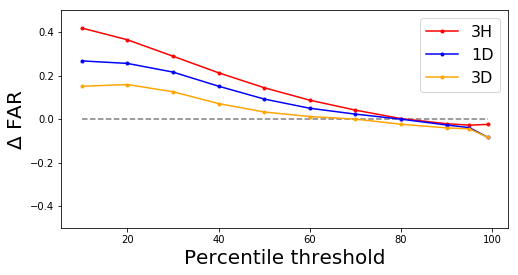

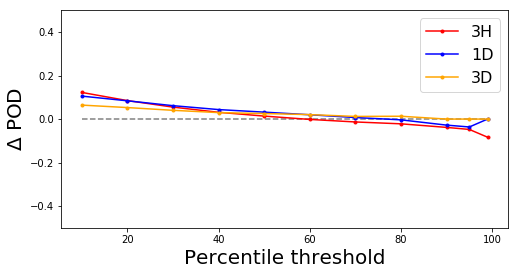

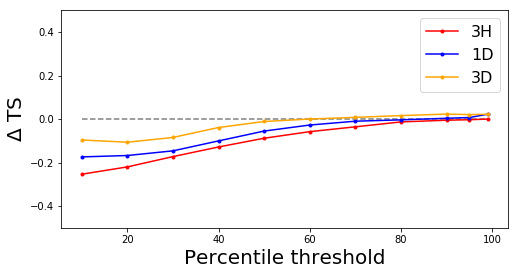

In [65]:
# --- Plot domain-median of delta at all thresholds --- #
# Calculate domain-median of delta
dict_delta_median = {}
for freq in list_freq:
    dict_delta_median[freq] = {}
    for perc in list_perc:
        dict_delta_median[freq][perc] = {}
        for var in ['FAR', 'POD', 'TS']:
            orig_median = float(dict_orig[freq][perc][var].median().values)
            corrected_median = float(dict_corrected[freq][perc][var].median().values)
            dict_delta_median[freq][perc][var] = corrected_median - orig_median
# Organize domain-median delta values into arrays
dict_list_delta = {}  # {var: freq: array of all thresholds}
for var in ['FAR', 'POD', 'TS']:
    dict_list_delta[var] = {}
    for freq in list_freq:
        list_delta_all_thresholds = []
        for perc in list_perc:
            list_delta_all_thresholds.append(dict_delta_median[freq][perc][var])
        array_all_thresholds = np.asarray(list_delta_all_thresholds)
        dict_list_delta[var][freq] = array_all_thresholds
# Plot
list_color = ['r', 'b', 'orange']
for var in ['FAR', 'POD', 'TS']:
    fig = plt.figure(figsize=(8, 4))
    plt.plot(list_perc, np.zeros(len(list_perc)), '--', color='Grey')
    for i, freq in enumerate(list_freq):
        plt.plot(list_perc, dict_list_delta[var][freq], '.-', color=list_color[i],
                 label=freq)
    # Makes plot look better
    plt.ylabel(r'$\Delta$ {}'.format(var), fontsize=20)
    plt.xlabel('Percentile threshold', fontsize=20)
    plt.legend(fontsize=16)
    plt.ylim([-0.5, 0.5])
    # Save figure
    fig.savefig(os.path.join(output_subdir_maps,
                             '{}.domain_mediaon_delta.png'.format(var)), format='png',
            bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Plot maps --- #
for freq in list_freq:
    for perc in list_perc:
        for var in ['FAR', 'POD', 'TS']:
            # Orig. precipitation
            fig = plt.figure(figsize=(14, 7))
            cs = dict_orig[freq][perc][var].plot(
                add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
            cbar = plt.colorbar(cs).set_label(var, fontsize=20)
            plt.title('{} of original precip., {}, percentile threshold = {}th\n'
                      'domain median = {:.2f}'.format(
                          var, freq, perc,
                          float(dict_orig[freq][perc][var].median().values)),
                      fontsize=20)
            fig.savefig(os.path.join(output_subdir_maps,
                                     '{}.prec_orig.{}.q{}.png'.format(var, freq, perc)),
                        format='png',
                        bbox_inches='tight', pad_inches=0)

            # Corrected. precipitation
            fig = plt.figure(figsize=(14, 7))
            cs = dict_corrected[freq][perc][var].plot(
                add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
            cbar = plt.colorbar(cs).set_label(var, fontsize=20)
            plt.title('{} of corrected precip., {}, percentile threshold = {}th\n'
                      'domain median = {:.2f}'.format(
                          var, freq, perc,
                          float(dict_corrected[freq][perc][var].median().values)),
                      fontsize=20)
            fig.savefig(os.path.join(output_subdir_maps,
                                     '{}.prec_corrected.{}.q{}.png'.format(var, freq, perc)),
                        format='png',
                        bbox_inches='tight', pad_inches=0)

            # Improvement
            if var == 'FAR':
                da_improv = dict_orig[freq][perc][var] - dict_corrected[freq][perc][var]
            else:
                da_improv = dict_corrected[freq][perc][var] - dict_orig[freq][perc][var]
            fig = plt.figure(figsize=(14, 7))
            cs = da_improv.plot(add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
            cbar = plt.colorbar(cs, extend='both').set_label(var, fontsize=20)
            plt.title('{} improvement, {}, percentile threshold = {}th\n'
                      'domain median = {:.2f}'.format(
                          var, freq, perc,
                          float(da_improv.median().values)),
                      fontsize=20)
            fig.savefig(os.path.join(output_subdir_maps,
                                     '{}.improv.{}.q{}.png'.format(var, freq, perc)),
                        format='png',
                        bbox_inches='tight', pad_inches=0)
        

In [ ]:
        
# ============================================================ #
# Plot precipitation RMSE maps
# ============================================================ #
print('Plotting RMSE...')
# --- Calculate RMSE --- #
# 3H
out_nc = os.path.join(output_subdir_data, 'rmse.orig.prec.3H.nc')
da_rmse_orig_3H = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3H', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.prec.3H.nc')
da_rmse_corrected_3H = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3H', log=False).where(da_mask)
# 1D
out_nc = os.path.join(output_subdir_data, 'rmse.orig.prec.1D.nc')
da_rmse_orig_1D = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='1D', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.prec.1D.nc')
da_rmse_corrected_1D = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='1D', log=False).where(da_mask)
# 3D
out_nc = os.path.join(output_subdir_data, 'rmse.orig.prec.3D.nc')
da_rmse_orig_3D = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3D', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.prec.3D.nc')
da_rmse_corrected_3D = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3D', log=False).where(da_mask)

# --- Calculate PER --- #
da_per_rmse_3H = (1 - da_rmse_corrected_3H / da_rmse_orig_3H) * 100
da_per_rmse_1D = (1 - da_rmse_corrected_1D / da_rmse_orig_1D) * 100
da_per_rmse_3D = (1 - da_rmse_corrected_3D / da_rmse_orig_3D) * 100


# --- Plot maps - 3 hourly --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_orig_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/3hours)', fontsize=20)
plt.title('RMSE of original precip., 3 hours\n'
          'domain median = {:.2f} mm/3hours'.format(
              float(da_rmse_orig_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_orig.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_corrected_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/3hours)', fontsize=20)
plt.title('RMSE of corrected precip., 3 hours\n'
          'domain median = {:.2f} mm/3hours'.format(
              float(da_rmse_corrected_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_corrected.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmse_3H.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-20, vmax=20)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmse, 3H\n'
          'domain median = {:.1f}%'.format(da_per_rmse_3H.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmse.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)


# --- Plot maps - 1 day --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_orig_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of original precip., 1 day\n'
          'domain median = {:.2f} mm/day'.format(
              float(da_rmse_orig_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_orig.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_corrected_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of corrected precip., 1 day\n'
          'domain median = {:.2f} mm/day'.format(
              float(da_rmse_corrected_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_corrected.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmse_1D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-20, vmax=20)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmse, 1 day\n'
          'domain median = {:.1f}%'.format(da_per_rmse_1D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmse.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- Plot maps - 3 days --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_orig_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=10)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/3days)', fontsize=20)
plt.title('RMSE of original precip., 3 days\n'
          'domain median = {:.2f} mm/3days'.format(
              float(da_rmse_orig_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_orig.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_corrected_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=10)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/3days)', fontsize=20)
plt.title('RMSE of corrected precip., 1 day\n'
          'domain median = {:.2f} mm/3days'.format(
              float(da_rmse_corrected_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_corrected.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmse_3D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-20, vmax=20)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmse, 3 days\n'
          'domain median = {:.1f}%'.format(da_per_rmse_3D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmse.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# ============================================================ #
# Plot precipitation RMSE_log maps
# ============================================================ #
# --- Calculate RMSE_log --- #
# 3H
out_nc = os.path.join(output_subdir_data, 'rmse.orig.logPrec.3H.nc')
da_rmseLog_orig_3H = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3H', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.logPrec.3H.nc')
da_rmseLog_corrected_3H = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3H', log=True).where(da_mask)
# 1D
out_nc = os.path.join(output_subdir_data, 'rmse.orig.logPrec.1D.nc')
da_rmseLog_orig_1D = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='1D', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.logPrec.1D.nc')
da_rmseLog_corrected_1D = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='1D', log=True).where(da_mask)
# 3D
out_nc = os.path.join(output_subdir_data, 'rmse.orig.logPrec.3D.nc')
da_rmseLog_orig_3D = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3D', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.logPrec.3D.nc')
da_rmseLog_corrected_3D = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3D', log=True).where(da_mask)

# --- Calculate PER --- #
da_per_rmseLog_3H = (1 - da_rmseLog_corrected_3H / da_rmseLog_orig_3H) * 100
da_per_rmseLog_1D = (1 - da_rmseLog_corrected_1D / da_rmseLog_orig_1D) * 100
da_per_rmseLog_3D = (1 - da_rmseLog_corrected_3D / da_rmseLog_orig_3D) * 100


# --- Plot maps - 3 hours --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_orig_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/3hours)', fontsize=20)
plt.title('RMSElog of original precip., 3 hours\n'
          'domain median = {:.2f} log_mm/3hours'.format(
              float(da_rmseLog_orig_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_orig.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_corrected_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/3hours)', fontsize=20)
plt.title('RMSElog of corrected precip., 3 hours\n'
          'domain median = {:.2f} log_mm/3hours'.format(
              float(da_rmseLog_corrected_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_corrected.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmseLog_3H.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-30, vmax=30)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmseLog, 3 hours\n'
          'domain median = {:.1f}%'.format(da_per_rmseLog_3H.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmseLog.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)


# --- Plot maps - 1 day --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_orig_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/day)', fontsize=20)
plt.title('RMSElog of original precip., 1 day\n'
          'domain median = {:.2f} log_mm/day'.format(
              float(da_rmseLog_orig_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_orig.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_corrected_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/day)', fontsize=20)
plt.title('RMSElog of corrected precip., 1 day\n'
          'domain median = {:.2f} log_mm/day'.format(
              float(da_rmseLog_corrected_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_corrected.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmseLog_1D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-30, vmax=30)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmseLog, 1 day\n'
          'domain median = {:.1f}%'.format(da_per_rmseLog_1D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmseLog.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)


# --- Plot maps - 3 days --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_orig_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/3days)', fontsize=20)
plt.title('RMSElog of original precip., 3 days\n'
          'domain median = {:.2f} log_mm/3days'.format(
              float(da_rmseLog_orig_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_orig.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_corrected_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/3days)', fontsize=20)
plt.title('RMSElog of corrected precip., 1 day\n'
          'domain median = {:.2f} log_mm/3days'.format(
              float(da_rmseLog_corrected_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_corrected.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmseLog_3D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-30, vmax=30)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmseLog, 3 days\n'
          'domain median = {:.1f}%'.format(da_per_rmseLog_3D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmseLog.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# ============================================================ #
# Plot precipitation correlation maps
# ============================================================ #
print('Plotting corr coef...')
# --- Calculate corrcoef --- #
# 3H
out_nc = os.path.join(output_subdir_data, 'corrcoef.orig.prec.3H.nc')
da_corrcoef_orig_3H = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3H', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoef.corrected.prec.3H.nc')
da_corrcoef_corrected_3H = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3H', log=False).where(da_mask)
# 1D
out_nc = os.path.join(output_subdir_data, 'corrcoef.orig.prec.1D.nc')
da_corrcoef_orig_1D = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='1D', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoef.corrected.prec.1D.nc')
da_corrcoef_corrected_1D = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='1D', log=False).where(da_mask)
# 3D
out_nc = os.path.join(output_subdir_data, 'corrcoef.orig.prec.3D.nc')
da_corrcoef_orig_3D = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3D', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoef.corrected.prec.3D.nc')
da_corrcoef_corrected_3D = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3D', log=False).where(da_mask)

# --- Calculate absolute improvement of corrcoef --- #
da_corrcoef_improv_3H = da_corrcoef_corrected_3H - da_corrcoef_orig_3H
da_corrcoef_improv_1D = da_corrcoef_corrected_1D - da_corrcoef_orig_1D
da_corrcoef_improv_3D = da_corrcoef_corrected_3D - da_corrcoef_orig_3D


# --- Plot maps - 3 hourly --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_orig_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoef of original precip., 3 hours\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_orig_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_orig.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_corrected_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoef of corrected precip., 3 hours\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_corrected_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_corrected.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_improv_3H.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoef, 3H\n'
          'domain median = {:.2f}'.format(da_corrcoef_improv_3H.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.improv.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)


# --- Plot maps - 1 day --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_orig_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoef of original precip., 1 day\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_orig_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_orig.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_corrected_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoef of corrected precip., 1 day\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_corrected_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_corrected.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_improv_1D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoef, 1 day\n'
          'domain median = {:.2f}'.format(da_corrcoef_improv_1D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.improv.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)


# --- Plot maps - 3 days --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_orig_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoef of original precip., 3 days\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_orig_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_orig.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_corrected_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoef of corrected precip., 3 days\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_corrected_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_corrected.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_improv_3D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoef, 3 days\n'
          'domain median = {:.2f}'.format(da_corrcoef_improv_3D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.improv.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)


# ============================================================ #
# Plot log_precipitation correlation maps
# ============================================================ #
# --- Calculate corrcoefLog --- #
# 3H
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.orig.prec.3H.nc')
da_corrcoefLog_orig_3H = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3H', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.corrected.prec.3H.nc')
da_corrcoefLog_corrected_3H = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3H', log=True).where(da_mask)
# 1D
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.orig.prec.1D.nc')
da_corrcoefLog_orig_1D = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='1D', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.corrected.prec.1D.nc')
da_corrcoefLog_corrected_1D = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='1D', log=True).where(da_mask)
# 3D
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.orig.prec.3D.nc')
da_corrcoefLog_orig_3D = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3D', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.corrected.prec.3D.nc')
da_corrcoefLog_corrected_3D = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3D', log=True).where(da_mask)

# --- Calculate absolute improvement of corrcoefLog --- #
da_corrcoefLog_improv_3H = da_corrcoefLog_corrected_3H - da_corrcoefLog_orig_3H
da_corrcoefLog_improv_1D = da_corrcoefLog_corrected_1D - da_corrcoefLog_orig_1D
da_corrcoefLog_improv_3D = da_corrcoefLog_corrected_3D - da_corrcoefLog_orig_3D


# --- Plot maps - 3 hourly --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_orig_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoefLog of original precip., 3 hours\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_orig_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_orig.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_corrected_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoefLog of corrected precip., 3 hours\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_corrected_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_corrected.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_improv_3H.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoefLog, 3H\n'
          'domain median = {:.2f}'.format(da_corrcoefLog_improv_3H.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.improv.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)


# --- Plot maps - 1 day --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_orig_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoefLog of original precip., 1 day\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_orig_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_orig.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_corrected_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoefLog of corrected precip., 1 day\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_corrected_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_corrected.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_improv_1D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoefLog, 1 day\n'
          'domain median = {:.2f}'.format(da_corrcoefLog_improv_1D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.improv.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)


# --- Plot maps - 3 days --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_orig_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoefLog of original precip., 3 days\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_orig_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_orig.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_corrected_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoefLog of corrected precip., 3 days\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_corrected_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_corrected.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_improv_3D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoefLog, 3 days\n'
          'domain median = {:.2f}'.format(da_corrcoefLog_improv_3D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.improv.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)